# Imports

dataset link: https://www.kaggle.com/arnaud58/horse2zebra

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import os
from PIL import Image 
import cv2
from torchvision import transforms 
from cv2_plt_imshow import cv2_plt_imshow as imshow
from matplotlib.pyplot import imshow as imshow2
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import string
import numpy as np
import glob
import random
import os
from skimage import io
from pathlib import Path
import itertools
import time
from tqdm import tqdm

In [33]:
torch.cuda.is_available()

True

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
%cd C:\Users\Michel\DataspellProjects\dls_1sem_project

C:\Users\Michel\DataspellProjects\dls_1sem_project


# split by folders

In [36]:
DIR = 'C:/Users/Michel/DataspellProjects/dls_1sem_project'

In [ ]:
os.makedirs(DIR+'/A/train')
os.makedirs(DIR+'/A/test')
os.makedirs(DIR+'/B/train')
os.makedirs(DIR+'/B/test')

In [ ]:
def create_folders(path,typ):
  if typ=='A':
    dr = 'tiger' 
  else:
    dr = 'cats'
    
  new_path = str(dr)
  files_names = [dir for dir in os.walk(new_path)]
  curr_count=0

  for folder, subfolders, files in os.walk(new_path):
    curr_path = os.path.abspath(folder)
    for img in files:
      filePath = os.path.join(curr_path, img)
      if img.endswith('.jpg'):
        curr_count+=1
      else:
        os.remove(filePath)
  counter = 0

  for folder, subfolders, files in os.walk(new_path):
    curr_path = os.path.abspath(folder)    
    for img in files:
      if img.endswith('.jpg'):
        filePath = os.path.join(curr_path, img)
        pic = cv2.imread(filePath) 
        if counter >= 0.8*curr_count:
          cv2.imwrite(DIR+'/'+typ+'/'+'test'+'/'+img, pic)
        else:
          # os.path.join(path+'\\'+str(typ)+'\\train',img)
          cv2.imwrite(DIR+'/'+typ+'/'+'train'+'/'+img, pic)
        counter+=1

In [ ]:
create_folders(DIR,'A')
create_folders(DIR,'B')

# Dataset & Dataloader

In [37]:
class Img2Tensor(Dataset):
  def __init__(self, path, mode):
    super().__init__()
    self.mode = mode
    self.img_A = glob.glob(os.path.join(path,'A',str(mode),'*.*'))
    self.img_B = glob.glob(os.path.join(path,'B',str(mode),'*.*'))
  def __getitem__(self, index):
    transform = transforms.Compose([
       transforms.CenterCrop(256),
       transforms.ToTensor(),
       transforms.Normalize([0, 0, 0], [1, 1, 1])                             
    ])
    item_A = transform(Image.open(self.img_A[index % len(self.img_A)]).convert('RGB'))
    item_B = transform(Image.open(self.img_B[index % len(self.img_B)]).convert('RGB'))
    return {'A': item_A, 'B': item_B}
  def __len__(self):
      return max(len(self.img_A), len(self.img_B))


In [38]:
data_train = Img2Tensor(DIR,mode='train')
dataloader_train = DataLoader(data_train, batch_size=3, shuffle=True)

In [39]:
data_test = Img2Tensor(DIR, mode='test')
dataloader_test = DataLoader(data_test, batch_size=1, shuffle=False)

In [40]:
test_real_A_data_2 = data_test.__getitem__(-1)['A'].unsqueeze(0)
test_real_B_data_2 = data_test.__getitem__(-1)['B'].unsqueeze(0)

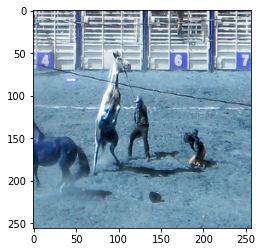

In [41]:
img_example = data_train.__getitem__(6)['A']
imshow(img_example.permute(1, 2, 0).detach().cpu().numpy())

In [42]:
img_list = []
counter = 0
for i in dataloader_train:
  img = i['A']
  if counter<=63:
    img_list.append(img[0])
  else:
    break
  counter+=1

In [43]:
img_list[1].shape

torch.Size([3, 256, 256])

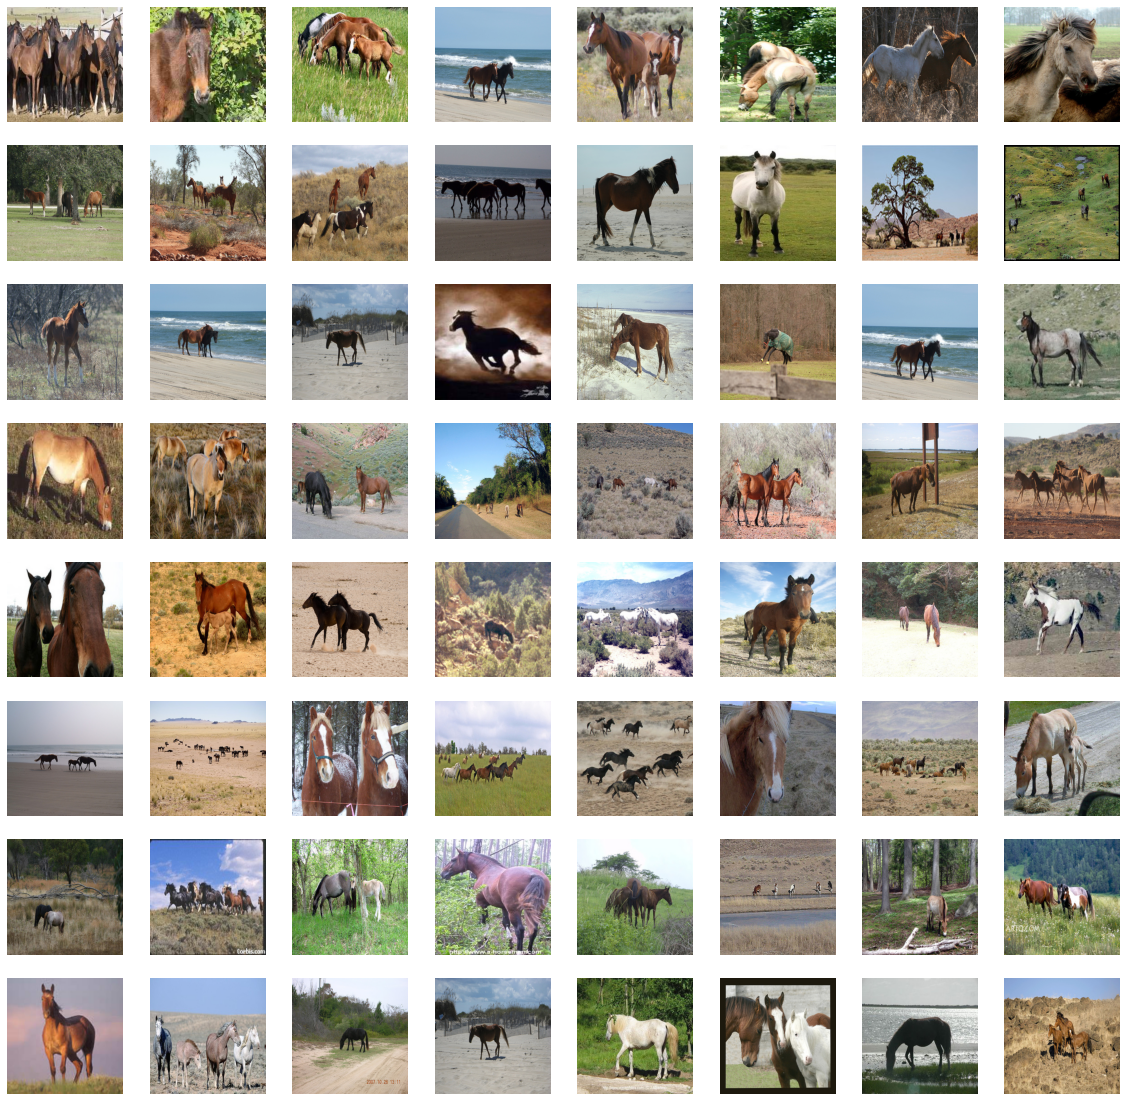

In [44]:
def show_many_examples(images, num_examples=64, figsize=(20, 20)):
  plt.figure(figsize=figsize)
  for k in range(num_examples):  
    plt.subplot(8, 8, k+1)
    plt.imshow(images[k].permute(1, 2, 0).detach().cpu().numpy())
    plt.axis('off')
  plt.show()
show_many_examples(img_list)

# ResNet Block

In [45]:
class ResNetBlock(nn.Module):
  def __init__(self,input_f):
    super(ResNetBlock, self).__init__()
    self.main_block = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(input_f,input_f,3),
        nn.InstanceNorm2d(input_f),

        nn.ReLU(),
        
        nn.ReflectionPad2d(1),
        nn.Conv2d(input_f,input_f,3),
        nn.InstanceNorm2d(input_f)
    )
  def forward(self,x):
    return x+self.main_block(x)

# Generator

In [46]:
class Generator1(nn.Module):
  def __init__(self,n_blocks=9):
    super(Generator1,self).__init__()
    
    #encoding

    self.encoding = nn.Sequential(
        nn.ReflectionPad2d(3), #1?
        nn.Conv2d(3, 64, kernel_size=7),
        nn.InstanceNorm2d(64),
        nn.ReLU(True),

        nn.Conv2d(64, 64*2, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(64*2),
        nn.ReLU(True),

        nn.Conv2d(64*2, 64*4, kernel_size=3, stride=2, padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(True)
    )

    #res Blocks
    for i in range(n_blocks):
      self.encoding = nn.Sequential(self.encoding, ResNetBlock(256))

    #decoding

    self.decoding = nn.Sequential(
        nn.ConvTranspose2d(64*4, 64*2, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(64*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(64*2, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(True),

        nn.ReflectionPad2d(3),
        nn.Conv2d(64, 3, kernel_size=7),
        nn.Tanh()
    )
    self.model = nn.Sequential(self.encoding, self.decoding)

  def forward(self, x):
      return self.model(x)

# Discriminator 

In [48]:
class Discriminator1(nn.Module):
  def __init__(self):
    super(Discriminator1,self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(64*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(64*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64*4, 64*8, kernel_size=4, stride=1, padding=1),
        nn.InstanceNorm2d(64*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64*8, 1, kernel_size=4, stride=1, padding=1)
    )
  def forward(self, x):
      return self.model(x)

In [50]:
class ImagePool():
  def __init__(self, pool_size = 50):
    self.pool_size = pool_size
    self.images = []
  def get_images(self, images):
    image_list = []
    for img in images:
      image = torch.unsqueeze(img.data, 0)
      if len(self.images) < self.pool_size:
        self.images.append(image)
        image_list.append(image)
      else:
        if random.uniform(0,1) > 0.5:
          i = random.randint(0, self.pool_size - 1)
          image_list.append(self.images[i].clone())
          self.images[i] = image
        else:
          image_list.append(image)
    return torch.cat(image_list)

In [51]:
def to_np(x):
    return x.data.cpu().numpy()

In [53]:
G_A2B = Generator1()
G_B2A = Generator1()
D_A = Discriminator1()
D_B = Discriminator1()

G_B2A.cuda()

D_B.cuda()
G_A2B.cuda()
D_A.cuda()

Discriminator1(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [54]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [55]:
optimizer_G = torch.optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()),lr=2e-4, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.5)

In [56]:
fake_pull_A = ImagePool()
fake_pull_B = ImagePool()

In [57]:
def plot_train_result(real_image, gen_image, recon_image, epoch, fig_size=(8, 5)):
    fig, axes = plt.subplots(2, 3, figsize=fig_size)

    imgs = [to_np(real_image[0]), to_np(gen_image[0]), to_np(recon_image[0]),
            to_np(real_image[1]), to_np(gen_image[1]), to_np(recon_image[1])]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch {0}'.format(epoch + 1)
    fig.text(0.5, 0.04, title, ha='center', fontsize=12, color='white')

    plt.show()

# Training loop

In [58]:
def train(n_epochs):
    G_A2B.train()
    G_B2A.train()
    G_A_losses = []
    G_B_losses = []
    D_A_losses = []
    D_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []

    for epoch in tqdm(range(n_epochs)):
        G_A_loss = 0
        G_B_loss = 0
        D_A_loss = 0
        D_B_loss = 0
        cycle_A_loss = 0
        cycle_B_loss = 0

        for i, data in enumerate(dataloader_train):
            real_A = data['A'].to(device)
            real_B = data['B'].to(device)

            for param in D_A.parameters():
                param.requires_grad = False
            for param in D_B.parameters():
                param.requires_grad = False
            
            optimizer_G.zero_grad()        
            # Identity loss
            same_B = G_A2B(real_B)
            loss_identity_B = criterion_identity(same_B, real_B)*5.0

            same_A = G_B2A(real_A)
            loss_identity_A = criterion_identity(same_A, real_A)*5.0


            fake_B = G_A2B(real_A)
            pred_fake = D_B(fake_B)
            target_real = torch.tensor(1., device=device).expand_as(pred_fake)
            loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

            fake_A = G_B2A(real_B)
            pred_fake = D_A(fake_A)
            loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

            # Cycle loss
            rec_A = G_B2A(fake_B)
            loss_cycle_ABA = criterion_cycle(rec_A, real_A)*10.0

            rec_B = G_A2B(fake_A)
            loss_cycle_BAB = criterion_cycle(rec_B, real_B)*10.0

            # Total loss
            loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            loss_G.backward()
            
            optimizer_G.step()

            for param in D_A.parameters():
                param.requires_grad = True
            for param in D_B.parameters():
                param.requires_grad = True

            # Discriminator A
            optimizer_D_A.zero_grad()

            # Real loss
            pred_real = D_A(real_A)
            loss_D_real = criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_A = fake_pull_A.get_images(fake_A)
            pred_fake = D_A(fake_A.detach())
            target_fake = torch.tensor(0., device=device).expand_as(pred_fake)
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_A = (loss_D_real + loss_D_fake)*0.5
            loss_D_A.backward()

            optimizer_D_A.step()


            # Discriminator B
            optimizer_D_B.zero_grad()

            # Real loss
            pred_real = D_B(real_B)
            loss_D_real = criterion_GAN(pred_real, target_real)
            
            # Fake loss
            fake_B = fake_pull_B.get_images(fake_B)
            pred_fake = D_B(fake_B.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_B = (loss_D_real + loss_D_fake)*0.5
            loss_D_B.backward()

            optimizer_D_B.step()

            G_A_loss += loss_GAN_A2B.item()
            G_B_loss += loss_GAN_B2A.item()
            D_A_loss += loss_D_A.item()
            D_B_loss += loss_D_B.item()
            cycle_A_loss += loss_cycle_ABA.item()
            cycle_B_loss += loss_cycle_BAB.item()
        data_length = len(dataloader_train)
        G_A_losses.append(G_A_loss / data_length)
        G_B_losses.append(G_B_loss / data_length)
        D_A_losses.append(D_A_loss / data_length)
        D_B_losses.append(D_B_loss / data_length)
        cycle_A_losses.append(cycle_A_loss / data_length)
        cycle_B_losses.append(cycle_B_loss / data_length)


        print('Generator A loss: {}, Generator B loss: {}'.format(G_A_losses[-1], G_B_losses[-1]))
        print('Discr A loss: {}, Discr B loss: {}'.format(D_A_losses[-1], D_B_losses[-1]))
        print('Cycle A loss: {}, Cycle B loss: {}'.format(cycle_A_losses[-1], cycle_B_losses[-1]))

        test_real_A_2 = test_real_A_data_2.cuda()
        test_fake_B_2 = G_A2B(test_real_A_2)
        test_rec_A_2 = G_B2A(test_fake_B_2)

        test_real_B_2 = test_real_B_data_2.cuda()
        test_fake_A_2 = G_B2A(test_real_B_2)
        test_rec_B_2 = G_A2B(test_fake_A_2)
        plot_train_result([test_real_A_2, test_real_B_2], [test_fake_B_2, test_fake_A_2], [test_rec_A_2, test_rec_B_2], epoch)

        scheduler.step()
    return G_A_losses, G_B_losses, D_A_losses, D_B_losses, cycle_A_losses, cycle_B_losses

# Training

In [ ]:
G_A_loss, G_B_loss, D_A_loss, D_B_loss, cycle_A_loss, cycle_B_loss = train(60)

In [64]:
loss_list = []
loss_list.append(G_A_loss)
loss_list.append(G_B_loss)
loss_list.append(D_A_loss)
loss_list.append(D_B_loss)
loss_list.append(cycle_A_loss)
loss_list.append(cycle_B_loss)


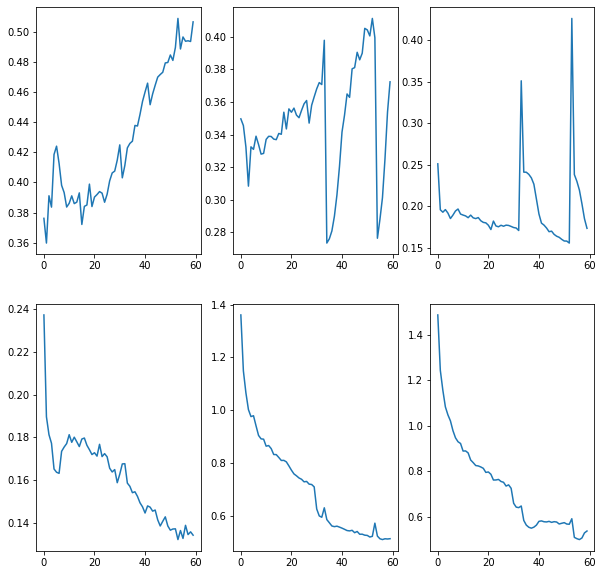

In [71]:
plt.figure(figsize=(10,10))
for k in range(len(loss_list)):  
  plt.subplot(2, 3, k+1)
  plt.plot(loss_list[k])

As expected, the generator losses initially decrease but then start to rise, while the discriminator losses continue to decrease.

In [60]:
def plot_test_result(test_images, length, test_class, fig_size=(20, 10)):
    fig, axes = plt.subplots(length // 5, length // (length // 5), figsize=fig_size)
    

    for ax, img in zip(axes.flatten(), test_images):
        ax.axis('off')
        ax.set_adjustable('box')
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    if test_class == 'A':
        title = 'Horse 2 zebra'.format(test_class)
        fig.text(0.5, 0.04, title, ha='center', fontsize=12, color='white')
    if test_class == 'B':
        title = 'Zebra 2 horse'.format(test_class)
        fig.text(0.5, 0.04, title, ha='center', fontsize=12, color='white')

    plt.show()

In [61]:
import sys

G_A2B.eval()
G_B2A.eval()
test_A = []
test_B = []

for i, batch in enumerate(dataloader_test):
    real_A = batch['A'].to(device)
    real_B = batch['B'].to(device)

    with torch.no_grad():
        fake_B = to_np(G_A2B(real_A))
        fake_A = to_np(G_B2A(real_B))

        fake_B = fake_B.squeeze()
        fake_B = (((fake_B - fake_B.min()) * 255) / (fake_B.max() - fake_B.min())).transpose(1, 2, 0).astype(np.uint8)
        test_B.append(fake_B)
        fake_B = Image.fromarray(fake_B)

        fake_A = fake_A.squeeze()
        fake_A = (((fake_A - fake_A.min()) * 255) / (fake_A.max() - fake_A.min())).transpose(1, 2, 0).astype(np.uint8)
        test_A.append(fake_A)
        fake_A = Image.fromarray(fake_A)

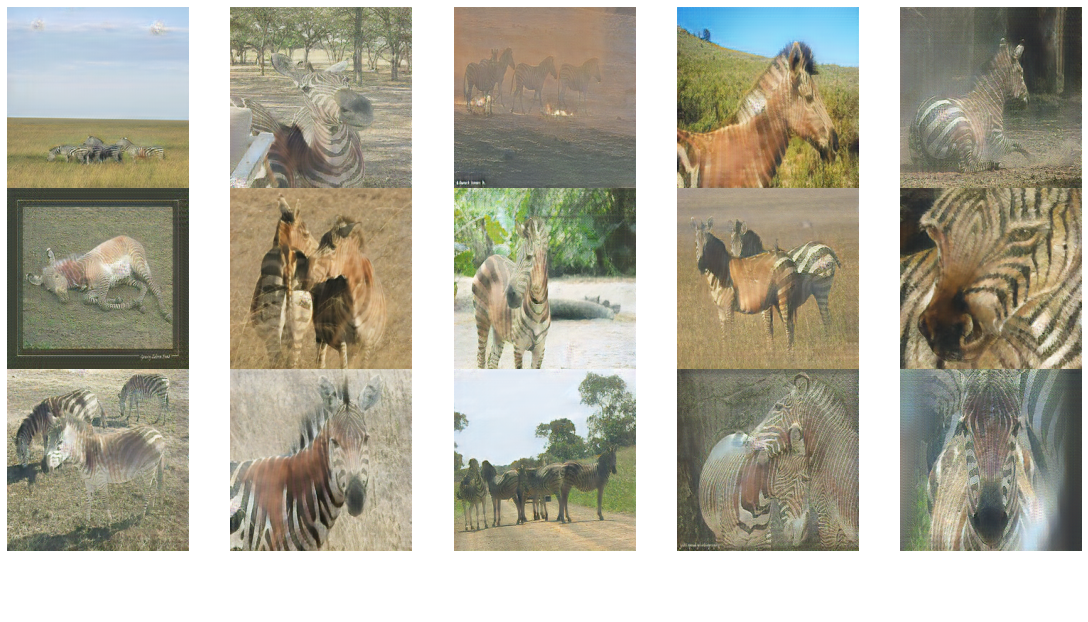

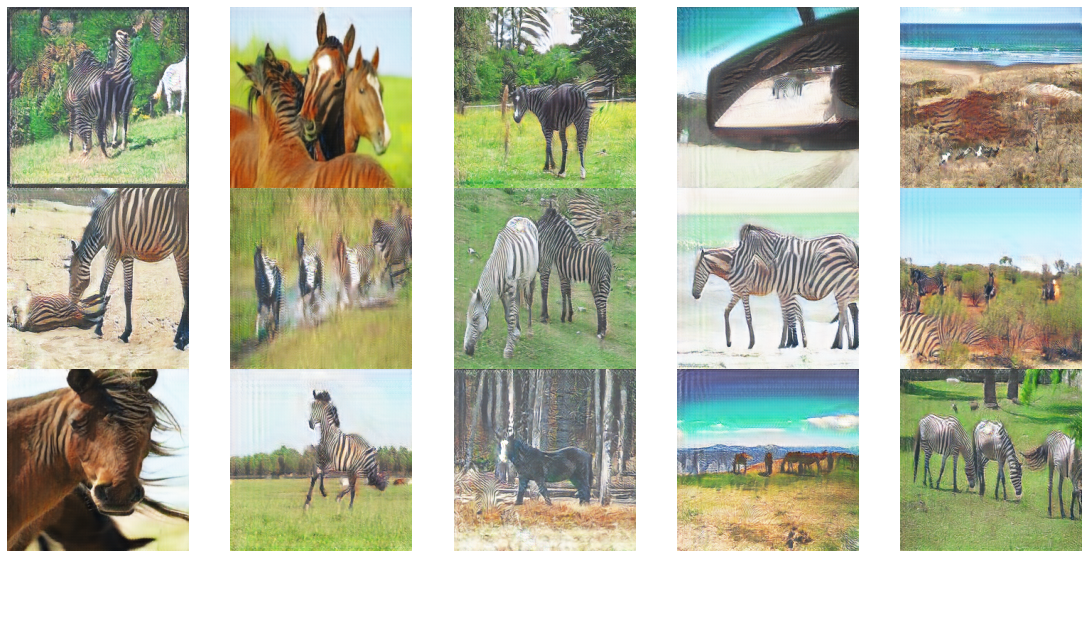

In [62]:
plot_test_result(test_A, 16, 'A')
plot_test_result(test_B, 16, 'B')

# Results

horse2zebra is the third dataset I’m trying for this task. Initially, I worked with the dog2cat dataset, but the results were poor (I only noticed later that the authors of the original paper had already warned that this dataset tends to yield bad results). I also tried cat2tiger, but the results were poor as well.

In the end, I used the horse2zebra dataset, trained the model for 60 epochs, and, overall, the results were similar to those achieved by the authors of the paper on this dataset.

# References

* https://towardsdatascience.com/cycle-gan-with-pytorch-ebe5db947a99

* https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

* https://arxiv.org/abs/1703.10593